In [325]:
#Importing necessary packages
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
import math 
import pandas as pd
from tqdm.notebook import tqdm
np.random.seed(89)
torch.manual_seed(42)

# Question-1:

## Generating Linearly Seperable Points:

In [326]:
def get_linearly_seperable_pts(gamma):
    
    #Generating the true classifier
    Wtrue = torch.rand(3,1)
    Wtrue[0]= 0.0
    
    #Generating DataPoints
    TotalPts = torch.normal(0,10,size=(2000,2))
    TotalPts = torch.cat((torch.ones(2000,1),TotalPts),dim=1)
    
    #Calculating gamma
    gamma1=torch.matmul(TotalPts,Wtrue)/torch.sqrt(Wtrue[1]**2+ Wtrue[2]**2)
    
    #List for positive and negative labels
    pos=[]
    neg=[]
    
    #Selecting DataPoints based on their gamma values
    for i in range(int(list(gamma1.shape)[0])):
        if gamma1[i]>gamma:
            pos.append(TotalPts[i].cpu().numpy())
        elif gamma1[i]<-gamma:
            neg.append(TotalPts[i].cpu().numpy())   
            
    #Sampling the selected DataPoints
    fpos=random.sample(pos,min(len(pos),len(neg),500))
    fneg=random.sample(neg,min(len(pos),len(neg),500))
    
    #Generating Labels for selected DataPoints
    lpos=torch.ones(len(fpos))
    lneg=-1*torch.ones(len(fneg))
    
    #Converting lists to Tensors
    fpos=torch.Tensor(np.array(fpos))
    fneg=torch.Tensor(np.array(fneg))
    
    return fpos,fneg,lpos,lneg,Wtrue

### Perceptron Training Algorithm:
1. Start with $w$ = 0
1. While $\exists n_k$ such that $y_{nk}(w^T_k \cdot x_{nk})\le 0$, update $w_{k+1} = w_k + y_{nk} \cdot x_{nk}$

In [327]:
#The Perceptron Training Algorithm
def train_perceptron(x, y, w, nb_epochs_max): 
    
    #'For' loop for epochs
    for e in range(nb_epochs_max):
        nb_changes = 0
        
        #'For' loop for all DataPoints
        for i in range(x.size(0)):
            
            #Update step for misclassifed DataPoints
            if x[i].dot(w) * y[i] <= 0:
                w = w + y[i] * x[i]
                nb_changes = nb_changes + 1
        
        #Early Stopping Condition
        if nb_changes == 0:
            print('Early stopping at epoch number',e) 
            break;
            
    return w,e

Early stopping at epoch number 13
Early stopping at epoch number 11
Early stopping at epoch number 30
Early stopping at epoch number 32
Early stopping at epoch number 3


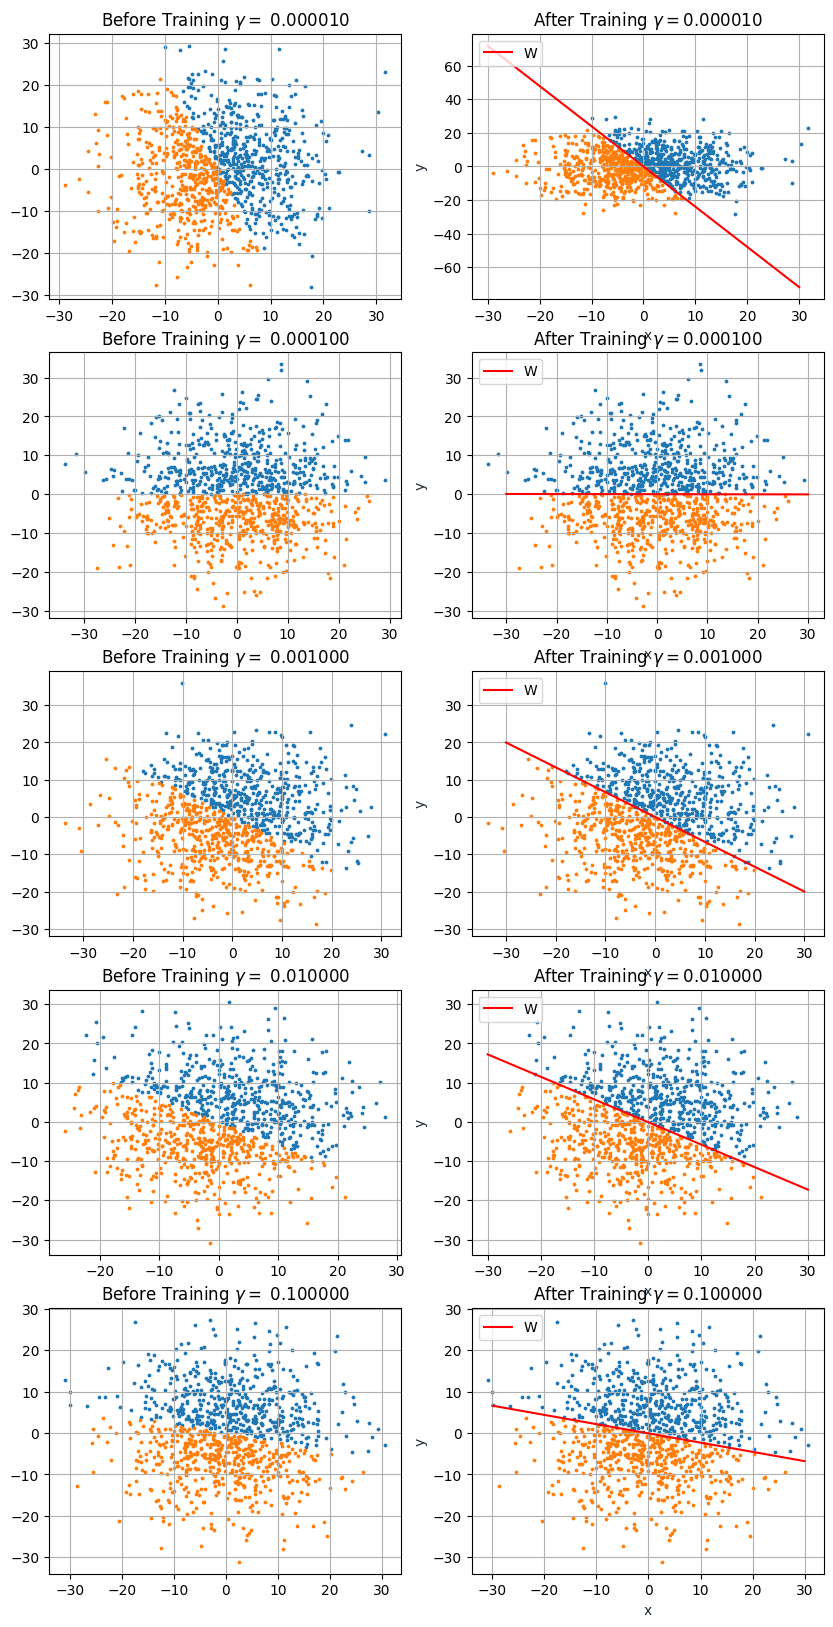

In [328]:
#Lists for gamma and storing number of epochs
gammalist = [1e-5,1e-4,1e-3,1e-2,1e-1]
epochlist=[]

#For plotting
j=1
plt.figure(figsize=(10,20)) 

#'For' loop for all gamma values
for i,gamma in enumerate(gammalist):
    
    #Obtaining DataPoints based on gamma
    pos,neg,lpos,lneg,Wtrue = get_linearly_seperable_pts(gamma)
    
    #Plotting data before classification
    plt.subplot(5,2,j)
    plt.scatter(pos[:,1],pos[:,2],s=3)
    plt.scatter(neg[:,1],neg[:,2],s=3)
    plt.grid()
    plt.title(f"Before Training $\gamma=$ %f" %gamma)
    j=j+1

    #DataSet Preprocessing
    W = torch.zeros_like(Wtrue.squeeze())
    y = torch.cat((lpos,lneg))
    x = torch.cat((pos,neg))
    
    #Training
    W,e = train_perceptron(x,y,W,150)
    epochlist.append(e)
    
    
    #Plotting data with classifier after classification
    x = np.linspace(-30,30,100)
    y = -(W[1].item()/W[2].item())*x - (W[0].item()/W[2].item())
    plt.subplot(5,2,j)
    plt.plot(x, y, '-r', label='W')
    plt.title(f"After Training $\gamma=$%f"%gamma)
    plt.xlabel('x', color='#1C2833')
    plt.ylabel('y', color='#1C2833')
    plt.legend(loc='upper left')
    plt.scatter(pos[:,1], pos[:,2],s=3)
    plt.scatter(neg[:,1], neg[:,2],s=3)
    plt.grid()
    j=j+1
plt.show()

### 1. We know that Perceptron Algorithm stops classifying as soon as it finds decision boundary rather than maximizing the margin like other algorithms. 
###  $\therefore$ The obtained classifiers are not symmetric

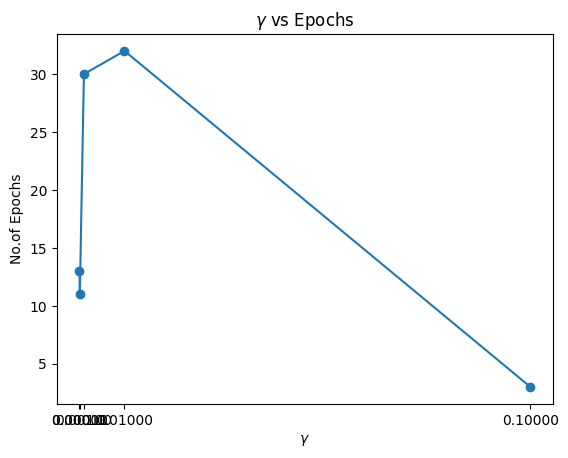

In [329]:
#Plotting gamma vs epochs
plt.plot(gammalist,epochlist,marker='o')
plt.xlabel('$\gamma$')
plt.ylabel('No.of Epochs')
plt.title('$\gamma$ vs Epochs')
plt.xticks(gammalist)
plt.show()

# Analysis:
1. We know that $k < \frac{R^2}{\delta^2}$ where $R$ is the maximum distance of a point from the classifier and $\delta$ is $y^i(w^{*} \cdot x^i)$.
2. As $R$ increases, k(iterations required to converge) increase and also as $\delta$ increases, k decreases.
3. Since the data used here used here is not too large, there are irregularities in the k vs $\gamma$

# Question-2:
I took Hinge loss as the loss function.

## Gradient Descent Algorithm:
For i in range(datapoints):<br />
   &nbsp;&nbsp;&nbsp;&nbsp; If $y^i(w \cdot x^i \le 0)$:<br />
     &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $w = w - \eta \nabla L_w$

# Hinge Loss:
Hinge Loss: $max( 0 , 1-yw^Tx)$ <br />
$\nabla L_w= \begin{cases} 0 & yw^Tx> 0\\ -yx & otherwise \end{cases}$
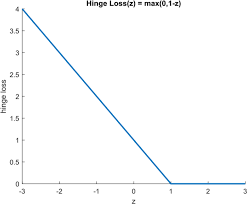

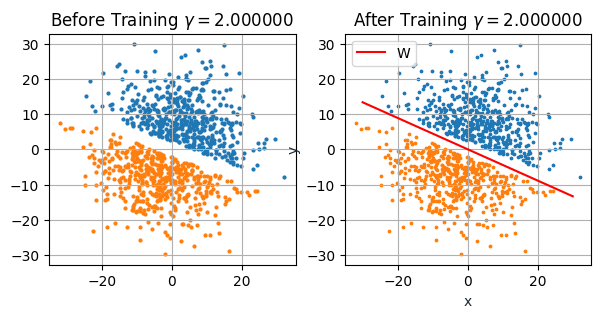

In [330]:
#Obtaining DataPoints
gamma = 2
pos,neg,lpos,lneg,Wtrue = get_linearly_seperable_pts(gamma)

#DataSet Preprocessing
Y = torch.cat((lpos,lneg))
X = torch.cat((pos,neg))

#Plotting DataSet
plt.figure(figsize=(7,3))
plt.subplot(1,2,1)
plt.scatter(pos[:,1], pos[:,2],s=4)
plt.scatter(neg[:,1], neg[:,2],s=4)
plt.title(f"Before Training $\gamma=$%f"%gamma)
plt.grid()

#Trainable Classifier
Wh = torch.zeros(X.shape[1])

#'For' loop for DataPoints
for i in range(X.shape[0]):
    
    #Gradient Computation and Update Equation
    if Y[i]*Wh.dot(X[i])<=0:
        Wh = Wh -0.01*Y[i]*X[i]

#Plotting DataPoints with trained Classifier
x = np.linspace(-30,30,100)
y = -(Wh[1].item()/Wh[2].item())*x - (Wh[0].item()/Wh[2].item())
plt.subplot(1,2,2)
plt.plot(x, y, '-r', label='W')
plt.title(f"After Training $\gamma=$%f"%gamma)
plt.xlabel('x', color='#1C2833')
plt.ylabel('y', color='#1C2833')
plt.legend(loc='upper left')
plt.scatter(pos[:,1], pos[:,2],s=3)
plt.scatter(neg[:,1], neg[:,2],s=3)
plt.grid()
plt.show()

# Question-3

## Multi-Layer Perceptron(MLP):
1. As Universal Approximation theorem states we can represent any continuous function with one hidden layer of perceptrons
1. Representation:
&nbsp;&nbsp;&nbsp;$x^{0} = x,\\ \forall l=1,\cdots,L, x^{l}=\sigma(W^{(l)^T}x^{(l-1)}+b^{l})$

# MLP Architecture:
1. This MLP network contains 1 hidden layer with 2 perceptrons.
1. Input dimension is 2 whereas output dimension is 1
1. Loss Function taken is Hinge loss which is the same loss function as in previous question

# Architecture Used:
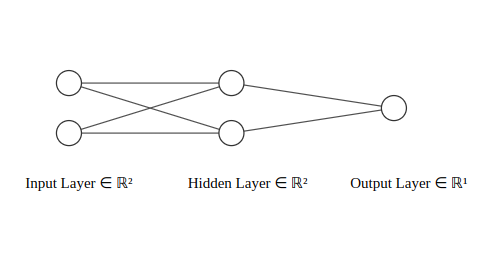

# Activation Function used at Hidden Layer and Output Layer:
McCulloch-Pitts Neuron Model's Activation:<br />
$
\sigma(z)=\begin{cases}
1 & z\ge 0\\ -1 & otherwise
\end{cases}
$

In [331]:
#Perceptron Function
def Perceptron(X):
    ans = np.zeros(X.shape)
    ans = np.where(X>=0,1,-1)
    return ans

In [332]:
#Calculating derivative of perceptron function wrt input
def first_term_calculation(Y,Ypred):
    ans=np.zeros(Y.shape)
    ans=np.where(Y==Ypred,0,-1)
    return ans

In [333]:
#Calculating derivative of loss with respect to perceptron(z)
def caldldperz(Y,perz):
    ans = np.zeros(Y.shape)
    initial = Y * perz
    two = np.ones(initial.shape)-initial
    ans = np.where(two>0,-Y,0)
    return ans

In [334]:
#Gradient Descent
def GD(w,derivate,lr=0.1):
    for i in range(derivate.shape[0]):
        w = w - lr*derivate[j]

In [335]:
#Generating Data
r = np.random.uniform([[4.5], [9]], [[6], [10.5]], size=(2, 1000))
angle = np.linspace(0, 2 * np.pi , 1000 )
X = [r[0] * np.cos(angle), r[1] * np.cos(angle)]
Y = [r[0] * np.sin(angle), r[1] * np.sin(angle)]

In [336]:
#Appending both labels Data into single data
X=torch.tensor(np.array(X))
Y=torch.tensor(np.array(Y))
X=X.reshape(-1,1)
Y=Y.reshape(-1,1)
X=torch.cat((X,Y),dim=1)
X=np.array(X)

In [337]:
#Generating Labels for DataPoints
lpos=torch.ones(1000)
lneg=-1*torch.ones(1000)
Y=torch.cat((lpos,lneg))
Y.reshape(-1,1)
Y=np.array(Y)
Y=Y.reshape(Y.shape[0],1)

In [338]:
#%%timeit
#Set no.of epochs and learning rate
epochs=100
lr = 0.1

#Pseudo-Randomized initialization of weights and biases
w1 = np.random.random((2,2))
w2 = np.random.random((2,1))
b1 = np.random.random((1,2))
b2 = np.random.random((1,1))

for epoch in tqdm(range(epochs)):
    
    #Forward Propagation
    
    #Layer1
    Layer1Input = X
    Layer1Output = X
    
    midProcess1 = np.dot(X,w1)
    
    #Layer2 
    Layer2Input = midProcess1 + b1
    Layer2Output = Perceptron(Layer2Input)
    
    midProcess2 = np.dot(Layer2Output,w2)    
    
    #Layer3 
    Layer3Input = midProcess2 + b2
    Layer3Output = Perceptron(Layer3Input)

    
    #BackPropagation
    dldperz = caldldperz(Y,Layer3Output)
    dperzdz = first_term_calculation(Y,Layer3Output)

    
    #Chain Rule
    dydw1 = np.dstack((X,X))
    dzdy = w2
    dzdw1 = dydw1 * dzdy.T
    dperzdw1 = np.tensordot(dperzdz.T,dzdw1,axes=((1),(0))).reshape(2,2)
    dldw1 = dperzdw1 * np.dstack((np.hstack((dldperz,dldperz)),np.hstack((dldperz,dldperz))))

    
    dzdw2 = Layer2Input
    dperzdw2 = dperzdz * dzdw2
    dldw2 = dldperz * dperzdw2
  
        
    dzdb2 = np.ones(b2.shape)
    dperzdb2 = dperzdz * dzdb2
    dldb2 = dperzdb2 * dldperz

    
    dydb1 = np.ones(b1.shape)
    dzdb1 = dydb1 * dzdy.T
    dperzdb1 = dperzdz * dzdb1
    dldb1 = dldperz * dperzdb1
        
    
    #Update Equations
    GD(w1,dldw1,lr)
    GD(w2,dldw2,lr)
    GD(b1,dldb1,lr)
    GD(b2,dldb2,lr)

  0%|          | 0/100 [00:00<?, ?it/s]

In [339]:
#Layer1
Layer1Input = X
Layer1Output = X
    
midProcess1 = np.dot(X,w1)

#Layer2 
Layer2Input = midProcess1 + b1
Layer2Output = Perceptron(Layer2Input)
    
midProcess2 = np.dot(Layer2Output,w2)    
    
#Layer3 
Layer3Input = midProcess2 + b2
Layer3Output = Perceptron(Layer3Input)

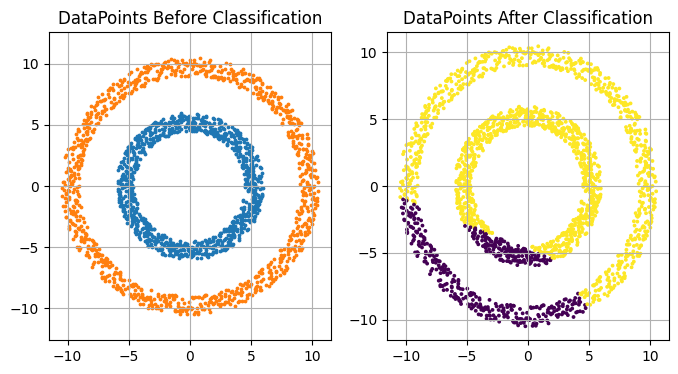

In [340]:
#Plotting Generated DataPoints
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.axis('equal')
plt.scatter(X[:1000,0], X[:1000,1],s=3)
plt.scatter(X[1000:,0], X[1000:,1],s=3)
plt.title('DataPoints Before Classification')
plt.grid()

#Plotting Resultant DataPoints
plt.subplot(1,2,2)
plt.scatter(X[:,0],X[:,1],c=Layer3Output,s=3)
plt.title('DataPoints After Classification')
plt.grid()
plt.show()

In [341]:
#Accuracy
(np.sum(Y==Layer3Output)/len(Layer3Output))*100

56.699999999999996